In [17]:
import tensorflow.keras as keras
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import os
import sys
import time
import tensorflow as tf

#### 1.1 打印版本

In [18]:
for module in keras, pd, np, tf, mpl, sklearn:
    print(module.__name__, module.__version__)

tensorflow.keras 2.4.0
pandas 1.3.2
numpy 1.18.5
tensorflow 2.3.0
matplotlib 3.4.3
sklearn 0.24.2


### 2. 处理数据集

#### 2.1 导入数据

- mnist数据集 : https://docs.pythontab.com/tensorflow/tutorials/mnist_beginners/#mnist

In [19]:
# 读取tf自带的数据集
fashion_mnist = tf.keras.datasets.fashion_mnist
# 加载数据
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
# 拆分训练集和验证集的数据
# 共60000张图片, 前5000张为验证集,后面都是测试集
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [20]:
print(np.max(x_train), np.min(x_train))

255 0


In [21]:
# 数据归一化 : x - means / std(方差)

from sklearn.preprocessing import  StandardScaler

scaler = StandardScaler()
# 对训练集和验证集做归一化, 另外 验证集归一化的时候需要训练集的均值和方差
# fit_transformer 输入值是二维矩阵, 另外 fit_transformer 会记录训练时的均值和方差
# x_train : [None, 28, 28] => [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)

x_valid_scaled = scaler.fit_transform(
    x_valid.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)

x_test_scaled = scaler.fit_transform(
    x_test.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)

In [22]:
print(np.max(x_train_scaled), np.min(x_train_scaled))

2.0231433 -0.8105136


#### 2.2 展示数据

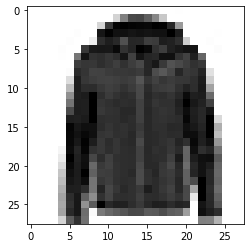

In [23]:
# 数据集都是向量数据, 直接输出无法显示图片, 需要借用matplotlib显示图片
def show_single_image(img_arr):
    # cmp 指的是数据类型
    plt.imshow(img_arr, cmap="binary")
    plt.show()


# 展示图片
show_single_image(x_train[0])

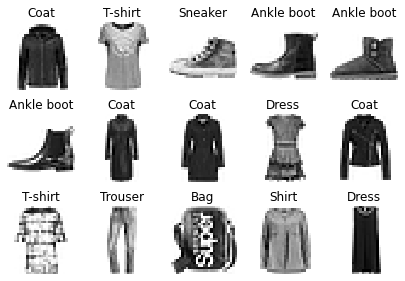

In [24]:
# 展示所有种类的数据
def show_imgs(n_rows, n_cols, x_data, y_data, class_names):
    # 断言, 判断x_data 和 y_data是否相等
    assert len(x_data) == len(y_data)
    assert n_rows * n_cols < len(x_data)

    # 创建画板
    plt.figure(figsize=(n_cols * 1.4, n_rows * 1.6))
    # 展示不同种类的图像
    for row in range(n_rows):
        for col in range(n_cols):
            # 获取索引
            index = n_cols * row + col
            # plt.subplot 用于绘制子图, 参考 : https://www.cnblogs.com/cgmcoding/p/13279406.html
            plt.subplot(n_rows, n_cols, index + 1)
            # interpolation 缩放图片时使用的方法
            plt.imshow(x_data[index], cmap="binary", interpolation="nearest")
            # 关闭坐标系
            plt.axis('off')
            # 设置标题
            plt.title(class_names[y_data[index]])


class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot']
show_imgs(3, 5, x_train, y_train, class_names)

### 3. 模型搭建

- Flatten : 输入层, Flatten 将 多维向量展平为一维向量
- Dense :
    1. 实现操作: output = activation(dot(input, kernel) + bias)
    2. 其中 activation 是作为激活参数传递的逐元素激活函数, kernel 是层创建的权重矩阵, bias 是创建的偏置向量

- 激活函数 :
    1. relu : y = max(0, x)
    2. softmax : 将向量变成概率分布 => x = [x1, x2, x3] -> y = [e^x1 / sum, e^x2 / sum, e^x3 / sum], e^x1 + e^x2 +e^x3 = sum

#### 3.1 搭建深度神经网络

In [25]:
# 创建模型
# model = keras.models.Sequential()
model = keras.models.Sequential()
# 添加输入层, Flatten 将 多维向量展平为一维向量
model.add(keras.layers.Flatten(input_shape=[28, 28]))
# 添加一个20层的深度神经网络
# 使用for 循环添加神经网络
for _ in range(20):
    model.add(keras.layers.Dense(units=64, activation="relu"))

# 添加最终输出层
model.add(keras.layers.Dense(units=10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])

In [26]:
# 查看模型的层数
model.layers

In [27]:
# 展示模型的架构, 以及可训练参数
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_24 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 64)               

- 全连接层参数计算
- [None, 784] * W + b(偏置) -> [None, 300] => W (参数) shape = [784, 300], b = [300] => 784 * 300 + 300 = 235500

#### 3.2 添加回调函数

- TensorBord : 查看模型训练期间的参数以及计算图
    1. tensorboard --logdir=./tf_keras_code/callbacks 可以查看TensorBoard网页
- Earlystopping : 设置终止训练的条件
- ModelCheckpoint : 保存模型

In [28]:
# 训练模型
# epochs : 训练轮数, validation_data : 验证集, 类型为 tuple(x_valid, y_valid)
# 返回值是训练过程中运行的一些数据结果

# callback : TensorBord , earlystopping, ModelCheckpoint
logdir = "./callbacks" # callback 输出目录
if not os.path.exists(logdir):
    os.mkdir(logdir)
# 设置模型保存目录
out_put_model_file = os.path.join(logdir , "fashion_mnist_model.H5")

callbacks = [
    keras.callbacks.TensorBoard(logdir), # TensorBoard
    keras.callbacks.ModelCheckpoint(out_put_model_file, save_best_only=True), # 保存准确率最高的模型
    # 达到某种条件自动中断模型训练
    # 1. min_delta 最近两次模型训练准确度的差值, 如果两次训练的差值过小 说明训练没有提升, 可以考虑中断训练
    # 2. patience : n 轮训  练没有提升后, 训练会被终止
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)
]

# 在 Command Prompt Shell 下 :
# 使用命令 : tensorboard --logdir=./tf_keras_code/callbacks 可以查看TensorBoard


history = model.fit(x_train_scaled, y_train, epochs=10,
                    validation_data=(x_valid_scaled, y_valid), callbacks=callbacks)

# print(x_train.shape, y_train.shape)

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 2.0579 - accuracy: 0.2201 - val_loss: 1.3760 - val_accuracy: 0.4342
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 1.0807 - accuracy: 0.5556 - val_loss: 0.9884 - val_accuracy: 0.5858
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.7074 - accuracy: 0.7407 - val_loss: 0.5723 - val_accuracy: 0.7994
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5590 - accuracy: 0.7926 - val_loss: 0.5287 - val_accuracy: 0.7932
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4928 - accuracy: 0.8156 - val_loss: 0.4660 - val_accuracy: 0.8340
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4508 - accuracy: 0.8346 - val_loss: 0.4785 - val_accuracy: 0.8244

In [29]:
type(history)

tensorflow.python.keras.callbacks.History

In [30]:
# GPU 和 CPU 训练的结果有很大不同
history.history

{'loss': [2.0579159259796143,
  1.0806866884231567,
  0.7074199318885803,
  0.5590441823005676,
  0.49278226494789124,
  0.45079556107521057,
  0.4274096190929413,
  0.3945186138153076,
  0.3592053949832916,
  0.33940306305885315],
 'accuracy': [0.22009091079235077,
  0.55558180809021,
  0.7406545281410217,
  0.7925817966461182,
  0.8155999779701233,
  0.8346182107925415,
  0.8446000218391418,
  0.8598909378051758,
  0.8730363845825195,
  0.8791272640228271],
 'val_loss': [1.3760126829147339,
  0.98838210105896,
  0.5723130106925964,
  0.528688907623291,
  0.46600884199142456,
  0.47847822308540344,
  0.4889613687992096,
  0.3854219317436218,
  0.36557698249816895,
  0.3570217788219452],
 'val_accuracy': [0.4341999888420105,
  0.5857999920845032,
  0.7993999719619751,
  0.7932000160217285,
  0.8339999914169312,
  0.824400007724762,
  0.8227999806404114,
  0.8655999898910522,
  0.8773999810218811,
  0.8740000128746033]}

#### 3.3 绘制图像

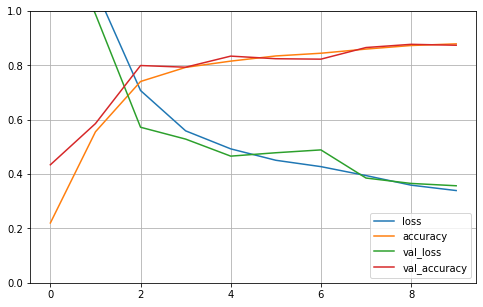

In [31]:
# 绘制图像
def plt_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    # 开启网格
    plt.grid(True)
    # 设置y轴范围
    plt.gca().set_ylim(0, 1)
    # 展示图像
    plt.show()

plt_learning_curves(history)

In [32]:
# 在测试集上评估
model.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3991 - accuracy: 0.8592

[0.399097740650177, 0.8592000007629395]

### 4. dropout 的使用

- AlphaDropout : 随机删除部分神经元, 防止过拟合
    1. 均值和方差不变
    2. 归一化性质不变
- model.add(keras.layers.AlphaDropout(rate=0.5))

#### 4.1 搭建模型

In [35]:
model = keras.models.Sequential()

# 添加神经网络层
model.add(keras.layers.Flatten(input_shape=[28, 28]))

# 添加隐含层
# 使用selu作为激活函数
model.add(keras.layers.Dense(units=64, activation=keras.activations.selu))
model.add(keras.layers.Dense(units=64, activation=keras.activations.selu))
# 添加dropout 防止过拟合
# AlphaDropout : 1. 均值和方差不变, 2. 归一化性质不变
model.add(keras.layers.AlphaDropout(rate=0.5)) # 随机移除0.5的神经元, 防止过拟合
# model.add(keras.layers.Dropout(rate=0.5)) # 随机移除0.5的神经元, 防止过拟合
# 添加最终输出层
model.add(keras.layers.Dense(units=10, activation="softmax"))

# 编译模型
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_46 (Dense)             (None, 64)                4160      
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 64)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


#### 4.2 训练模型

In [38]:
history = model.fit(x_train_scaled, y_train, epochs=20, validation_data=(x_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3766 - accuracy: 0.8650 - val_loss: 0.5026 - val_accuracy: 0.8744

In [39]:
history.history

{'loss': [0.3765595853328705,
  0.3697851896286011,
  0.36707478761672974,
  0.3638383448123932,
  0.3592636287212372,
  0.3571358919143677,
  0.35665684938430786,
  0.34973591566085815,
  0.3487666845321655,
  0.3441455364227295,
  0.3453609049320221,
  0.3402823805809021,
  0.33791959285736084,
  0.3355025351047516,
  0.3319735825061798,
  0.33353227376937866,
  0.3296656012535095,
  0.3252986967563629,
  0.32448750734329224,
  0.3206367790699005],
 'accuracy': [0.8650363683700562,
  0.8688181638717651,
  0.8681454658508301,
  0.8697817921638489,
  0.8720545172691345,
  0.8731091022491455,
  0.8724363446235657,
  0.8737999796867371,
  0.8748182058334351,
  0.8741454482078552,
  0.8759636282920837,
  0.8759636282920837,
  0.8785091042518616,
  0.8764545321464539,
  0.8783272504806519,
  0.8797818422317505,
  0.8797454833984375,
  0.8808727264404297,
  0.8812181949615479,
  0.8831090927124023],
 'val_loss': [0.5026452541351318,
  0.48979848623275757,
  0.5155581831932068,
  0.477074027

#### 4.3 绘制图像

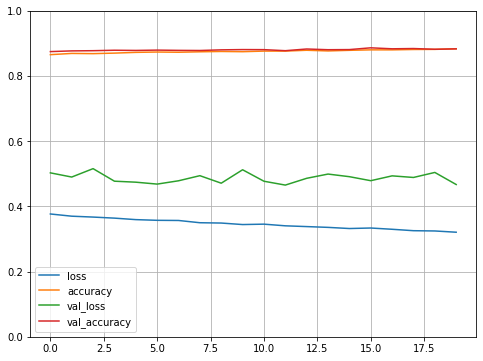

In [41]:
def plot_metric(history):
    pd.DataFrame(history.history).plot(figsize=(8,6))
    plt.gca().set_ylim(0,1)
    plt.grid(True) # 开启网格
    plt.show()

plot_metric(history)